# Generating matrices with a constant cross product
## Companion document for *An AO-ADMM approach to constraining PARAFAC2 on all modes*
**Marie Roald, Carla Schenker, Rasmus Bro, Jeremy E. Cohen, Evrim Acar**

This notebook contains code that can be used to generate sets of matrices, $\{\mathbf{B}_k\}_{k=1}^K$ , with a constant cross product. That is, sets of matrices that satisfy:
$$\mathbf{B}_{k_1}^\mathsf{T} \mathbf{B}_{k_1} = \mathbf{B}_{k_2}^\mathsf{T} \mathbf{B}_{k_2}, $$
for all pairs $k_1, k_2$.

Each section corresponds to an experiment setup in the paper, which can be reffered to for more details.


In [ ]:
import numpy as np
from scipy import special, stats
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [ ]:
def plot_cross_product(Bks):
    """Plot the cross product of each B_k-matrix.

    If the cross product is constant, the plot should consist of only straight
    horisontal lines.
    """
    R = Bks[0].shape[1]
    cross_products = np.stack([(Bk.T@Bk)[np.triu_indices(R)] for Bk in Bks], axis=-1)
    i = np.arange(R)
    cols, rows = np.meshgrid(i, i)
    cols, rows = cols[np.triu_indices(R)], rows[np.triu_indices(R)]
    labels = [r"$[\mathbf{B}_{k}^\mathsf{T} \mathbf{B}_{k}]_{%d %d}$" %(row, col) for row, col in zip(rows, cols)]

    fig, ax = plt.subplots()
    ax.set_title("Elements of the (symmetric) cross product matrix")

    ax.set_ylabel("Cross product")
    ax.set_xlabel("$k$")
    for cross_product, label in zip(cross_products, labels):
        ax.plot(cross_product, label=label)
    ax.legend(ncol=2)
    plt.show()

# Setup 1: Non-negative shifting components for comparison with flexible coupling

In [ ]:
def generate_B_setup1(J, K, R):
    blueprint = np.random.standard_normal(size=(J, R))
    blueprint = np.maximum(blueprint, 0)
    return [np.roll(blueprint, i, axis=0) for i in range(K)]

In [ ]:
num_attempts = 5
J = 40
K = 50
R = 3
B_setup1 = generate_B_setup1(J, K, R)

@widgets.interact(k=(0, K-1))
def replot(k):
    plt.plot(B_setup1[k])
    plt.title(f"$\mathbf{{B_{{{k}}}}}$")
    plt.xlabel("J")

interactive(children=(IntSlider(value=24, description='k', max=49), Output()), _dom_classes=('widget-interact'…

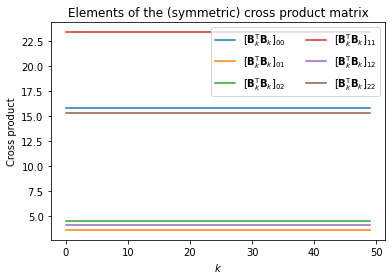

In [ ]:
plot_cross_product(B_setup1)

# Setup 2: General non-negativity setup with various levels of noise

In [ ]:
def generate_cross_product(r, n=100):
    temp = np.random.uniform(size=(n, r))
    temp = np.random.standard_normal(size=(n, r))
    temp[temp<0] = 0

    DtD = temp.T@temp
    return DtD


def random_matrix_constrained_cross_product(J, cross_product):
    DtD = cross_product
    success = False
    stepsize = 1e-3
    itermax = 10000
    tol = 1e-12

    for attempt in range(10):
        err = []
        B = np.random.standard_normal(size=(J, DtD.shape[0]))

        for i in range(itermax):
            # gradient step
            B = B - stepsize * 4*(B@(B.T@B) - B@DtD)
            B[B < 0] = 0

            err.append(np.linalg.norm(B.T@B - DtD)**2)
            if err[-1] < tol:
                success = True
                break
        else:
            stepsize /= 10

        if success:
            return B

    raise RuntimeError("Didn't find a decomposition")

def generate_B_setup2(J_MIN, J_MAX, K, R):
    cross_product = generate_cross_product(R)
    return [random_matrix_constrained_cross_product(np.random.randint(J_MIN, J_MAX), cross_product) for _ in range(K)]

In [ ]:
num_attempts = 5
J_min, J_max = 50, 100
K = 40
R = 3
B_setup2 = generate_B_setup2(J_min, J_max, K, R)

@widgets.interact(k=(0, K-1))
def replot(k):
    plt.plot(B_setup2[k])
    plt.title(f"$\mathbf{{B_{{{k}}}}}$")
    plt.xlabel("J")

interactive(children=(IntSlider(value=19, description='k', max=39), Output()), _dom_classes=('widget-interact'…

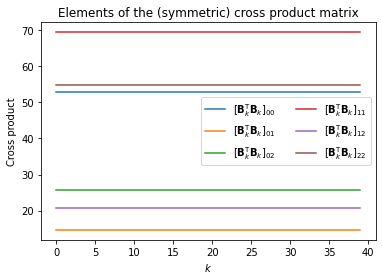

In [ ]:
plot_cross_product(B_setup2)

# Setup 3: Shifting unimodal non-negative components

In [ ]:
def generate_B_col(J):
    sigma = np.random.uniform(0.5, 1)
    shift = round(np.random.uniform(-J/3, 0))
    t = np.linspace(-10, 10, J)
    return np.roll(stats.norm.pdf(t, scale=sigma), shift)


def generate_blueprint_B(J, R):
    return np.stack([generate_B_col(J) for _ in range(R)], axis=-1)


def generate_B_setup3(J, K, R):
    blueprint_B = generate_blueprint_B(J, R)
    return [np.roll(blueprint_B, shift, axis=0) for shift in range(K)]

In [ ]:
J = 50
K = 15
R = 5
B_setup3 = generate_B_setup3(J, K, R)

@widgets.interact(k=(0, K-1))
def replot(k):
    plt.plot(B_setup3[k])
    plt.title(f"$\mathbf{{B_{{{k}}}}}$")
    plt.xlabel("J")

interactive(children=(IntSlider(value=7, description='k', max=14), Output()), _dom_classes=('widget-interact',…

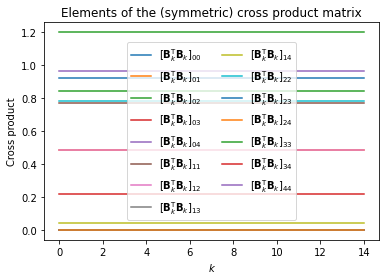

In [ ]:
plot_cross_product(B_setup3)

# Setup 4: Smooth cubic functions for graph Laplacian regularisation

In [ ]:
def random_orthogonal(J, R):
    return np.linalg.qr(np.random.standard_normal((J, R)))[0]

def generate_B_setup4(J, K, R, max_order):
    coordinate_matrix = np.random.standard_normal(size=(R, R))

    basis_matrices = []
    for k in range(K):
        t = np.linspace(-1, 1, J)
        polys = np.stack([t**order for order in range(max_order + 1)], axis=-1)
        U, s, Vh = np.linalg.svd(polys, full_matrices=False)
        basis_matrices.append(U@random_orthogonal(max_order + 1, R))
    return [basis_matrix @ coordinate_matrix for basis_matrix in basis_matrices]

In [ ]:
J = 200
K = 30
R = 3
MAX_ORDER = 3

B_setup4 = generate_B_setup4(J, K, R, MAX_ORDER)

@widgets.interact(k=(0, K-1))
def replot(k):
    plt.plot(B_setup4[k])
    plt.title(f"$\mathbf{{B_{{{k}}}}}$")
    plt.xlabel("J")

interactive(children=(IntSlider(value=14, description='k', max=29), Output()), _dom_classes=('widget-interact'…

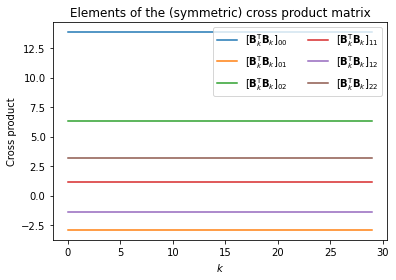

In [ ]:
plot_cross_product(B_setup4)

# Setup 5: Piecewise constant components for TV regularisation

In [ ]:
def column_constant_orthogonal(J, R):
    # Generate random partition
    P = np.zeros((J, R))
    while np.linalg.matrix_rank(P) != R:
        P *= 0
        indices = J*np.cumsum(np.random.dirichlet(np.ones(R)))
        indices = [0] + np.round(indices).astype(int).tolist()
        value = np.random.standard_normal()
        for r, (start, stop) in enumerate(zip(indices[:-1], indices[1:])):
            P[start:stop, r] = value


    return P / np.linalg.norm(P, axis=0)


def generate_B_setup5(J_MIN, J_MAX, K, R, num_signals):
    coordinate_matrix = np.zeros((num_signals, R))
    while np.any(np.sum(np.abs(coordinate_matrix), axis=0) == 0):
        for column in range(R):
            selected_signals = np.random.choice(num_signals, 2, replace=False)
            coordinate_matrix[selected_signals, column] = np.random.standard_normal(2)

    basis_matrices = [
        column_constant_orthogonal(np.random.randint(J_MIN, J_MAX), num_signals)
        for k in range(K)
    ]
    return [basis_matrix @ coordinate_matrix for basis_matrix in basis_matrices]

In [ ]:
J_min = 200
J_max = 251
K = 30
R = 3
NUM_SIGNALS = 4
B_setup5 = generate_B_setup5(J_min, J_max, K, R, NUM_SIGNALS)

@widgets.interact(k=(0, K-1))
def replot(k):
    plt.plot(B_setup5[k])
    plt.title(f"$\mathbf{{B_{{{k}}}}}$")
    plt.xlabel("J")

interactive(children=(IntSlider(value=14, description='k', max=29), Output()), _dom_classes=('widget-interact'…

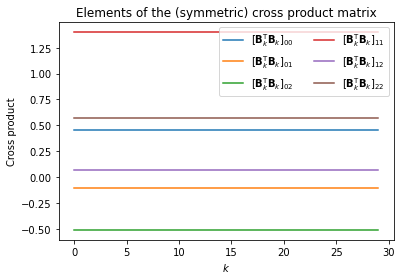

In [ ]:
plot_cross_product(B_setup5)

# Setup 6: Shifting non-negative components for evaluating the cwSNR

In [ ]:
J = 40
K = 100
R = 5

blueprint = np.random.standard_normal((J, R))
blueprint[blueprint < 0] = 0
B_setup6 = [np.roll(blueprint, k, axis=0) for k in range(K)]


@widgets.interact(k=(0, K-1))
def replot(k):
    plt.plot(B_setup6[k])
    plt.title(f"$\mathbf{{B_{{{k}}}}}$")
    plt.xlabel("J")

interactive(children=(IntSlider(value=49, description='k', max=99), Output()), _dom_classes=('widget-interact'…

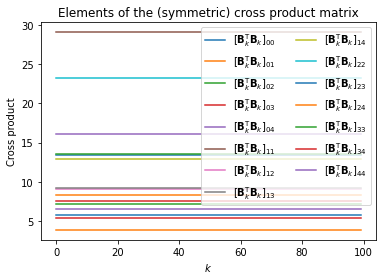

In [ ]:
plot_cross_product(B_setup6)

# Setup SM1: Product of non-negative matrices for comparison of different update rules

In [ ]:
def shuffle_matrix(A):
    shuffle_indices = np.arange(A.shape[0])
    np.random.shuffle(shuffle_indices)

    A = A[shuffle_indices, :]
    return A


def non_negative_orthogonal(J, R):
    # Generate random partition
    P = np.zeros((J, R))
    while np.linalg.matrix_rank(P) != R:
        P *= 0
        indices = J*np.cumsum(np.random.dirichlet(np.ones(R)))
        indices = [0] + np.round(indices).astype(int).tolist()
        for r, (start, stop) in enumerate(zip(indices[:-1], indices[1:])):
            P[start:stop, r] = np.random.uniform(size=stop - start)
      
    
    return shuffle_matrix(P / np.linalg.norm(P, axis=0))



def generate_B_setupsm1(K, J, R):
    blueprint = np.random.uniform(size=(R, R))
    blueprint += np.eye(R)
    Pks = [non_negative_orthogonal(J, R) for _ in range(K)]
    return [Pk@blueprint for Pk in Pks]


In [ ]:
J = 100
K = 70
R = 3
B_setupsm1 = generate_B_setupsm1(J, K, R)


@widgets.interact(k=(0, K-1))
def replot(k):
    plt.plot(B_setupsm1[k])
    plt.title(f"$\mathbf{{B_{{{k}}}}}$")
    plt.xlabel("J")

interactive(children=(IntSlider(value=34, description='k', max=69), Output()), _dom_classes=('widget-interact'…

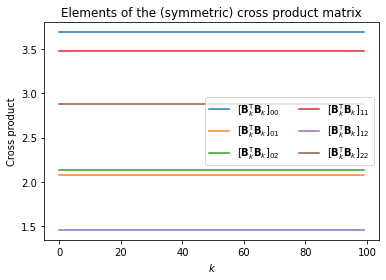

In [ ]:
plot_cross_product(B_setupsm1)